# Import des Netzwerks für das Modell

### Einrichtung

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math

import pypsa
import pypsa.plot as bmplot

%matplotlib inline

## Setup

Einrichtung aller wichtigen Kompnenten und Einlesen der Daten

Die jeweiligen Daten entstammen einer anderen Bachelorarbeit und werden über die von pandas zur Verfügung gestellten Funktionen aus Excel-Dateien eingelesen und als Dataframe gespeichert. Aus diesem werden dann wiederum nur die benötigten Werte verwendet.

### Variablen

In [2]:
nw = pypsa.Network()

In [3]:
dates = pd.date_range("2015-11-01T04:00:00Z", periods=5, freq="4H")

nw.set_snapshots(dates)

### Einlesen der Datenbanken

In [4]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

Zuerst werden die zur Verfügung gestellten Daten eingelesen, danach werden diese noch um einige benötigte Werte von Hand erweitert, die zur Durchführung des Unit Commitment nötig sind

In [5]:
# Einlesen der Kraftwerke
gen_data = [pd.DataFrame for i in range(2)]
ex = pd.ExcelFile(cur_path + "Technische Daten Gaskraftwerke.xlsx")

for i in range(len(gen_data)):
    # Extract last two columns from worksheet and only rows 5-14
    gen_data[i] = ex.parse(i).iloc[4:13,[-2,-1]]
    # Use values from first column as index
    gen_data[i].index = gen_data[i].iloc[:,0]
    # Delete column in the middle
    gen_data[i] = gen_data[i].iloc[:, -1]
    gen_data[i].set_value("committable", True)

In [6]:
# Einlesen der Wind- und Lastdaten
wind_data = pd.read_excel(cur_path + "Stromlast und Windeinspeisung.xlsx",
                    sheet_name="Tabelle1",
                    header=3,
                    index_col=0,
                    parse_cols="A:F")

# Extract only the first day, every Xh
intervall = 16
wind_data_modell = wind_data.iloc[intervall::intervall,[0,1]].head((96//intervall)-1)

### Temporary Additional code
### ================================================

In [7]:
filenames = ["vertices", "lines", "loads_modell"]
units = ["Bus", "Line", "Load"]
components = [pd.DataFrame for i in range(len(filenames))]

In [8]:
# importing the other components as DataFrames
for i in range(len(components)):
    components[i] = pd.read_csv(cur_path + filenames[i] + ".csv")
    components[i].fillna(0,inplace=True)

components[1].rename(columns={"wid":"x","len":"length","cap":"s_nom"},inplace=True)

In [9]:
#adapting the load-data
wind_data_modell["Last"] = wind_data_modell["Last"]/7
gen_data[1][1] = gen_data[1][1]*3

### ================================================

Einlesen der als *.csv gespeicherten Daten in ein pandas DataFrame, alle NaN werden durch 0 ersetzt

Uebertragen der Daten von pandas in das Netzwerk

In [10]:
for i in range(len(components)):
    pypsa.io.import_components_from_dataframe(nw, components[i], units[i])

In [11]:
gen_temp_df = pd.DataFrame({1:gen_data[0], 2:gen_data[1]})

In [12]:
pypsa.io.import_components_from_dataframe(nw, gen_temp_df.T, "Generator")

In [13]:
gen_temp_df.T

Unnamed: 2,name,p_nom,efficiency,carrier,ramp_limit_up,ramp_limit_down,p_min,bus,marginal_cost,committable
1,Fortuna,3500,0.6039,gas,35,35,50,2,30,True
2,SGT5-2000E,9000,0.35657,gas,10,10,50,2,50,True


In [14]:
nw.add("Generator", "0",
       bus=2,
       carrier="wind",
       p_nom="3000",
       committable=True,
       efficiency=0.95,
       ramp_limit_up=100,
       ramp_limit_down=100,
       marginal_cost=5,
       p_min="5")

In [15]:
# wind_temp_df

In [16]:
nw.buses

,Unnamed: 3,carrier,control,name,sub_network,type,v_mag_pu_max,v_mag_pu_min,v_mag_pu_set,v_nom,x,y
0,0.0,AC,PQ,mybus0,,,inf,0.0,1.0,1.0,50.0,10.0
1,0.0,AC,PQ,mybus1,,,inf,0.0,1.0,1.0,70.0,10.0
2,0.0,AC,PQ,mybus2,,,inf,0.0,1.0,1.0,60.0,40.0
3,0.0,AC,PQ,northsea0,,,inf,0.0,1.0,1.0,60.0,80.0


In [26]:
nw.lines

,b,b_pu,bus0,bus1,capital_cost,g,g_pu,id,length,name,...,s_nom_min,s_nom_opt,sub_network,terrain_factor,type,v_ang_max,v_ang_min,x,x_pu,v_nom
0,0.0,0.0,0,1,0.0,0.0,0.0,0.0,40.0,myline0,...,0.0,3000.0,0,1.0,,inf,-inf,0.0001,0.0001,1.0
1,0.0,0.0,1,2,0.0,0.0,0.0,1.0,31.6,myline1,...,0.0,3000.0,0,1.0,,inf,-inf,0.0001,0.0001,1.0
2,0.0,0.0,2,0,0.0,0.0,0.0,2.0,31.6,myline2,...,0.0,3000.0,0,1.0,,inf,-inf,0.0001,0.0001,1.0
3,0.0,0.0,3,2,0.0,0.0,0.0,3.0,40.0,offshoreline,...,0.0,6000.0,0,1.0,,inf,-inf,0.0001,0.0001,1.0


In [18]:
nw.generators.T[["0", "1", "2"]]

,0,1,2
bus,2,2,2
capital_cost,0,0,0
carrier,wind,gas,gas
committable,True,True,True
control,PQ,PQ,PQ
efficiency,0.95,0.6039,0.35657
initial_status,1,1,1
marginal_cost,5,30,50
min_down_time,0,0,0
min_up_time,0,0,0


Einlesen der Werte pro Zeitintervall

In [19]:
wind_temp_df = pd.DataFrame({"0":wind_data_modell["Windeinspeisung Original"]})
wind_temp_df.index = nw.snapshots
# nw.import_series_from_dataframe(wind_temp_df, "Generator", "p_set")

In [20]:
nw.generators_t.p_set["0"] = wind_temp_df["0"]

In [21]:
load_temp_df = pd.DataFrame({"0":wind_data_modell["Last"]})
load_temp_df.index = nw.snapshots
# nw.import_series_from_dataframe(load_temp_df, "Load", "p_set")
nw.loads_t.p_set["0"] = load_temp_df["0"]

## Aufbereitung der Daten

In [22]:
nw.lopf()

INFO:pypsa.pf:Slack bus for sub-network 0 is 2
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 603310.0
  Upper bound: 603310.0
  Number of objectives: 1
  Number of constraints: 140
  Number of variables: 71
  Number of nonzeros: 302
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 7
      Number of created subproblems: 7
  Error rc: 0
  Time: 0.0370028018951416
# ----------------------------------------------------------
#   Solution Information
# ---------------------------

('ok', 'optimal')

## Visualization

In [23]:
gen_outs = nw.generators_t.p
caps_by_carrier = nw.generators.groupby("carrier")["p_nom"].sum()
gen_pot_remaining = nw.generators.p_nom - gen_outs

Line graph to display the dispatched amount of energy per plant

Text(0,0.5,'MW')

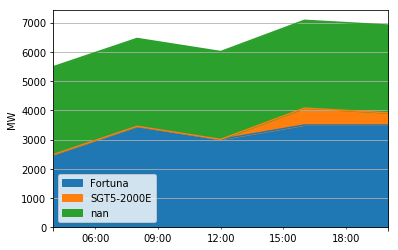

In [24]:
gen_plot = gen_outs.plot(kind="area",grid=True)
lines, labels = gen_plot.get_legend_handles_labels()
gen_plot.legend(lines[:len(nw.generators)], nw.generators['name'].values.tolist(), loc='best')
plt.ylabel("MW")

network graph showing the distribution of buses etc.

In [30]:
nw.generators_t.p_nom_opt

AttributeError: p_nom_opt

(0, 120)

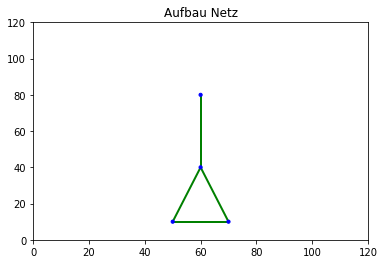

In [25]:
bmplot.plot(nw, title="Aufbau Netz")
plt.xlim([0,120])
plt.ylim([0,120])